# Visualizing tweets and the Logistic Regression model

**Objectives:** Visualize and interpret the logistic regression model

**Steps:**
* Plot tweets in a scatter plot using their positive and negative sums.
* Plot the output of the logistic regression model in the same plot as a solid line

## Import the required libraries

We will be using [*NLTK*](http://www.nltk.org/howto/twitter.html), an opensource NLP library, for collecting, handling, and processing Twitter data. In this lab, we will use the example dataset that comes alongside with NLTK. This dataset has been manually annotated and serves to establish baselines for models quickly. 

So, to start, let's import the required libraries. 

In [2]:
import nltk
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples
from utils import build_freqs, process_tweet

## Load the NLTK sample dataset

To complete this lab, you need the sample dataset of the previous lab. Here, we assume the files are already available, and we only need to load into Python lists.

In [3]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

tweets = all_positive_tweets + all_negative_tweets ## Concatenate the lists. 
positive_labels = np.ones((len(all_positive_tweets),1))
negative_labels = np.zeros((len(all_negative_tweets),1))
labels = np.append(positive_labels, negative_labels, axis = 0)

# split the data into two pieces, one for training and one for testing (validation set) 
train_pos  = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]
train_neg  = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg
train_y = np.append(positive_labels[:4000], negative_labels[:4000], axis=0)
print(f"train_y.shape = {train_y.shape}")
test_x = test_pos + test_neg
test_y = np.append(positive_labels[4000:], negative_labels[4000:], axis=0)
print(f"test_y.shape = {test_y.shape}")

print("Number of tweets in training set: ", len(train_x))
print("Number of tweets in test set: ", len(test_x))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)
Number of tweets in training set:  8000
Number of tweets in test set:  2000


Create the frequency dictionary using the imported build_freqs() function.
We highly recommend that you open utils.py and read the build_freqs() function to understand what it is doing.


In [4]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11339


## Process tweet
The given function `process_tweet()` tokenizes the tweet into individual words, removes stop words and applies stemming.

In [5]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


## Part 2: Extracting the features

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set. 

### Instructions: Implement the extract_features function. 
* This function takes in a single tweet.
* Process the tweet using the imported `process_tweet()` function and save the list of tweet words.
* Loop through each word in the list of processed words
    * For each word, check the `freqs` dictionary for the count when that word has a positive '1' label. (Check for the key (word, 1.0)
    * Do the same for the count for when the word is associated with the negative label '0'. (Check for the key (word, 0.0).)

In [6]:
def extract_features(tweet, freqs):
    tweet_words = process_tweet(tweet)
    # first column is bias, second positive word count, third negative word count
    feature_vector = np.zeros((1, 3))
    feature_vector[0, 0] = 1
    for word in tweet_words:
        feature_vector[0, 1] += freqs.get((word, 1.0), 0)
        feature_vector[0, 2] += freqs.get((word, 0.0), 0)
    return feature_vector
                

In [7]:
# test extract features on a sample tweet
test_features = extract_features(train_x[0], freqs)
print(test_features)

[[1.00e+00 3.02e+03 6.10e+01]]


In [8]:
# extract the features from training and test sets
train_X = np.zeros((len(train_x), 3))
test_X = np.zeros((len(test_x), 3))
for i, tweet in enumerate(train_x):
    train_X[i, :] = extract_features(tweet, freqs)
for i, tweet in enumerate(test_x):
    test_X[i, :] = extract_features(tweet, freqs)

print(train_X.shape)
print(test_X.shape)

(8000, 3)
(2000, 3)


## Train your logistic regression classifier (we use sklearn's implementation)

In [9]:
from sklearn.linear_model import LogisticRegression
sentiment_model = LogisticRegression()
sentiment_model.fit(train_X, train_y.ravel())
theta = sentiment_model.coef_[0]
theta

array([ 0.49652958,  0.00903886, -0.01025961])

In [10]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(train_X, train_y.ravel())

MultinomialNB()

In [12]:
# test the trained model by predicting sentiment of a sample tweet
sample_pos_tweet = train_x[0]
sample_neg_tweet = train_x[5001]
test_tweet1 = test_x[1005]

def predict_tweet_sentiment(model, tweet, label):
    print(f"\nTweet = {tweet}")    
    tweet_input_features = extract_features(tweet, freqs)
    scores = model.decision_function(tweet_input_features)
    print(f"Cost function h(x) = {scores[0]}")
    predicted_sentiment = model.predict(tweet_input_features)
    predicted_sentiment = predicted_sentiment[0]
    print(f"Predicted sentiment = {predicted_sentiment}")
    predict_probab = model.predict_proba(tweet_input_features)
    print(f"Predicted probability = {predict_probab[:, 1][0]}")
    if predicted_sentiment == 1:
        print(f'The tweet is predicted positive. Actual label = {label[0]}')
    elif predicted_sentiment == 0 :
        print(f'The tweet is predicted negative. Actual label = {label[0]}')

predict_tweet_sentiment(sentiment_model, sample_pos_tweet, train_y[0])
predict_tweet_sentiment(sentiment_model, sample_neg_tweet, train_y[5001])
predict_tweet_sentiment(sentiment_model, test_tweet1, test_y[1005])


Tweet = #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Cost function h(x) = 27.664637982366237
Predicted sentiment = 1.0
Predicted probability = 0.999999999999033
The tweet is predicted positive. Actual label = 1.0

Tweet = Saturday Classes! :(
Cost function h(x) = -36.7092584260029
Predicted sentiment = 0.0
Predicted probability = 1.141225930121312e-16
The tweet is predicted negative. Actual label = 0.0

Tweet = It's really hot :-(
Cost function h(x) = -3.2567629227319994
Predicted sentiment = 0.0
Predicted probability = 0.03708463019730508
The tweet is predicted negative. Actual label = 0.0


In [16]:
mnb.predict(extract_features(sample_pos_tweet, freqs))

array([[0., 1.]])

## Check performance using the test set
After training your model using the training set above, check how your model might perform on real, unseen data, by testing it against the test set.

#### Instructions: Implement `test_logistic_regression` 
* Given the test data and the weights of your trained model, calculate the accuracy of your logistic regression model. 
* Use your `predict_tweet()` function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification `y_hat` to 1, otherwise set the model's classification `y_hat` to 0.
* A prediction is accurate when `y_hat` equals `test_y`.  Sum up all the instances when they are equal and divide by `m`.

In [20]:
def get_prediction_accuracy(predicted_labels, true_labels):    
    # Compute the number of correctly classified examples
    is_correct = predicted_labels == true_labels    
    # Then compute accuracy by dividing num_correct by total number of examples
    accuracy = len(predicted_labels[is_correct]) / len(is_correct)    
    return round(accuracy, 2), is_correct

test_predicted_labels = sentiment_model.predict(test_X)
mnb_predicted_labels = mnb.predict(test_X)
accuracy, is_correct = get_prediction_accuracy(test_predicted_labels, test_y.ravel())
mnb_accuracy, mnb_is_correct = get_prediction_accuracy(mnb_predicted_labels, test_y.ravel())
print(f"Naive bayes accuracy = {mnb.score(test_X, test_y)}")
sklearn_accuracy = sentiment_model.score(test_X, test_y)
print(f"Accuracy of logistic regression sentiment classifier = {accuracy}") 
print(f"Accuracy of logistic regression sentiment classifier using sklearn inbuilt score method = {sklearn_accuracy}")

Naive bayes accuracy = 0.995
Accuracy of logistic regression sentiment classifier = 0.99
Accuracy of logistic regression sentiment classifier using sklearn inbuilt score method = 0.9915


In [22]:
test_X

array([[1.000e+00, 3.214e+03, 4.140e+02],
       [1.000e+00, 3.236e+03, 3.970e+02],
       [1.000e+00, 1.363e+03, 3.280e+02],
       ...,
       [1.000e+00, 2.600e+01, 3.717e+03],
       [1.000e+00, 7.000e+00, 3.672e+03],
       [1.000e+00, 1.000e+02, 4.530e+02]])

## Analyze the errors in tweet classification

In [23]:
# Error analysis
test_x = np.array(test_x)
mispredicted_tweets = test_x[~is_correct]
print(f"Number of misclassified tweets = {len(mispredicted_tweets)}")
test_tweets = np.concatenate((test_x.reshape(-1, 1), test_predicted_labels.reshape(-1, 1), test_y.reshape(-1, 1)), 
                            axis=1)
df_test_tweets = pd.DataFrame({'Tweet': pd.Series(test_x, dtype='str'),
                               'Predicted_Label': pd.Series(test_predicted_labels, dtype='float'),
                               'True_Label': pd.Series(test_y.ravel(), dtype='float')})                            
print(test_tweets.shape)
df_test_tweets.head()

Number of misclassified tweets = 17
(2000, 3)


,Tweet,Predicted_Label,True_Label
0,"Bro:U wan cut hair anot,ur hair long Liao bo\n...",1.0,1.0
1,@heyclaireee is back! thnx God!!! i'm so happy :),1.0,1.0
2,@BBCRadio3 thought it was my ears which were m...,1.0,1.0
3,@HumayAG 'Stuck in the centre right with you. ...,1.0,1.0
4,Happy Friday :-) http://t.co/iymPIlWXFY,1.0,1.0


In [25]:
# some of the misclassified tweets predicted using logistic regression
df_misclassified_tweets = df_test_tweets[~is_correct]
df_misclassified_tweets

,Tweet,Predicted_Label,True_Label
84,@MarkBreech Not sure it would be good thing 4 ...,0.0,1.0
129,I'm playing Brain Dots : ) #BrainDots\nhttp://...,0.0,1.0
136,I'm playing Brain Dots : ) #BrainDots http://t...,0.0,1.0
530,I'm playing Brain Dots : ) #BrainDots http://t...,0.0,1.0
822,@msarosh Uff Itna Miss karhy thy ap :p,0.0,1.0
1103,"Get in the bin, OSX/Chrome/Voiceover &gt;:( ht...",1.0,0.0
1298,@phenomyoutube u probs had more fun with david...,1.0,0.0
1364,@bumkeyyfel b-butt : ( isn't black cat a bad l...,1.0,0.0
1544,pats jay : (,1.0,0.0
1569,@bae_ts WHATEVER STIL L YOUNG &gt;:-(,1.0,0.0


Misclassified tweets predicted using naive bayes

In [24]:
df_mnb_misclassified_tweets = df_test_tweets[~mnb_is_correct]
df_mnb_misclassified_tweets

,Tweet,Predicted_Label,True_Label
129,I'm playing Brain Dots : ) #BrainDots\nhttp://...,0.0,1.0
136,I'm playing Brain Dots : ) #BrainDots http://t...,0.0,1.0
530,I'm playing Brain Dots : ) #BrainDots http://t...,0.0,1.0
822,@msarosh Uff Itna Miss karhy thy ap :p,0.0,1.0
1298,@phenomyoutube u probs had more fun with david...,1.0,0.0
1544,pats jay : (,1.0,0.0
1569,@bae_ts WHATEVER STIL L YOUNG &gt;:-(,1.0,0.0
1756,my beloved grandmother : ( https://t.co/wt4oXq...,1.0,0.0
1773,@CHEDA_KHAN Thats life. I get calls from peopl...,1.0,0.0
1873,@ITVCentral #Midlands Yes thanks for the depre...,1.0,0.0


In [15]:
test_x[84]

'@MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p'

In [16]:
words = set(np.array(list(freqs.keys()))[:, 0])
len(words)
# create a dataframe of all words and their corresponsing positive and negative counts
word_count = []
for word in words:
    word_count.append([word, freqs.get((word, 1), 0), freqs.get((word, 0), 0)])
df_word_count = pd.DataFrame(word_count, columns=['word', 'positive_count', 'negative_count'])      
df_word_count.head()

,word,positive_count,negative_count
0,loud,0,1
1,mubarak,1,0
2,teen,3,5
3,selo,1,0
4,antagonist,0,1


In [17]:
misclassified_tweet_words = set()
for tweet in df_misclassified_tweets['Tweet']:
    misclassified_tweet_words.update(process_tweet(tweet))
print(f"Distinct words in misclassified tweets = {len(misclassified_tweet_words)}")    
print(misclassified_tweet_words)    
df_mis_word_count = df_word_count[df_word_count['word'].isin(misclassified_tweet_words)]
df_mis_word_count.head()

Distinct words in misclassified tweets = 94
{'bottom', 'itna', 'ye', 'chrome', 'voiceov', 'seen', 'analyst', 'nothavingit', 'thing', 'peopl', ':-(', 'remind', 'havent', 'ap', 'sr', 'sure', 'b-butt', 'financi', 'alway', 'dot', 'total', 'good', 'grandmoth', 'life', 'thank', 'play', 'u', 'pat', 'sever', 'wa', 'mouth', 'weather', 'mine', 'expedia', 'mention', '20', 'someon', 'im', 'b', 'thi', 'get', 'time', 'cat', 'fun', 'wonho', 'black', 'bitch', 'rain', 'luck', 'miss', ':p', 'bad', 'inc', '“', 'dare', 'david', 'forecast', 'would', 'gonna', "i'm", '4', '>:-(', 'osx', 'word', 'l', 'put', 'that', 'call', 'cant', 'depress', 'karhi', 'bellevu', 'braindot', '...', '>:(', 'young', 'stubborn', 'brain', 'midland', 'prob', 'belov', '2', 'soap', 'stil', 'uff', 'favour', 'bin', 'jay', 'year', 'say', 'finger', 'internet', 'whatev', 'ene'}


,word,positive_count,negative_count
92,that,10,9
162,good,191,83
273,prob,5,4
319,wa,0,1
347,rain,18,36


## Visualize the words in misclassified tweets
Check if we can see any interesting trend. Note that the red line divides the area into two, the area below the red line towards the x axis is for positive sentiment words and the other is for negative sentiment words. We can see the words in misclassified are mostly near the red line meaning they have a neutral tone and hence the model has less prediction accuracy for tweets with such words

<function matplotlib.pyplot.show(close=None, block=None)>

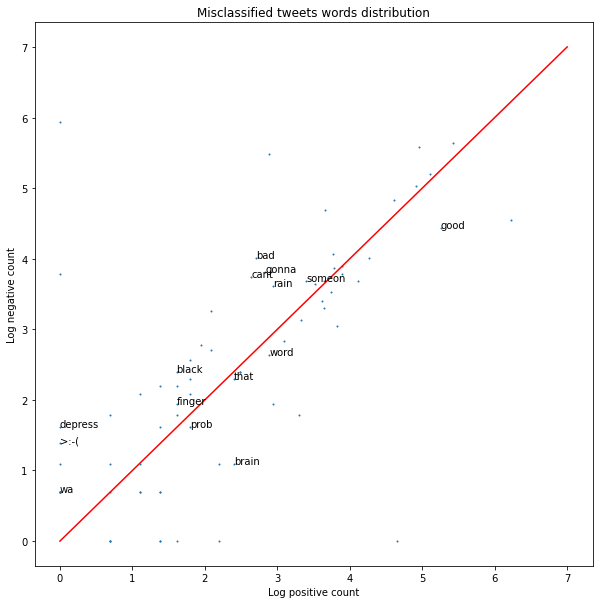

In [33]:
x = np.log(df_mis_word_count.iloc[:, 1] + 1).values
y = np.log(df_mis_word_count.iloc[:, 2] + 1).values
misclassified_tweet_words = df_mis_word_count.iloc[:, 0].values.astype('str')

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, s=1.0)
plt.xlabel('Log positive count')
plt.ylabel('Log negative count')
plt.title('Misclassified tweets words distribution')

# Add the word as the label at the same position as you added the points just before
for i, word in enumerate(misclassified_tweet_words[:15]):
    ax.annotate(word, (x[i], y[i]), fontsize=10)

ax.plot([0, 7], [0, 7], color='red')
plt.show

In [21]:
print(test_X[1005])
print(test_x[1005])
print(freqs.get((':(', 0)))
print(freqs.get((':(', 1)))

[  1.  86. 490.]
It's really hot :-(
3663
1


In [22]:
X = np.append(train_X, test_X, axis=0)
Y = np.append(train_y, test_y, axis=0)
print(f"X.shape = {X.shape}, Y.shape = {Y.shape}")

X.shape = (10000, 3), Y.shape = (10000, 1)


## Plot the samples in a scatter plot

The vector theta represents a plane that split our feature space into two parts. Samples located over that plane are considered positive, and samples located under that plane are considered negative. Remember that we have a 3D feature space, i.e., each tweet is represented as a vector comprised of three values: `[bias, positive_sum, negative_sum]`, always having `bias = 1`. 

If we ignore the bias term, we can plot each tweet in a cartesian plane, using `positive_sum` and `negative_sum`. In the cell below, we do precisely this. Additionally, we color each tweet, depending on its class. Positive tweets will be green and negative tweets will be red.

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='Positive', ylabel='Negative'>)

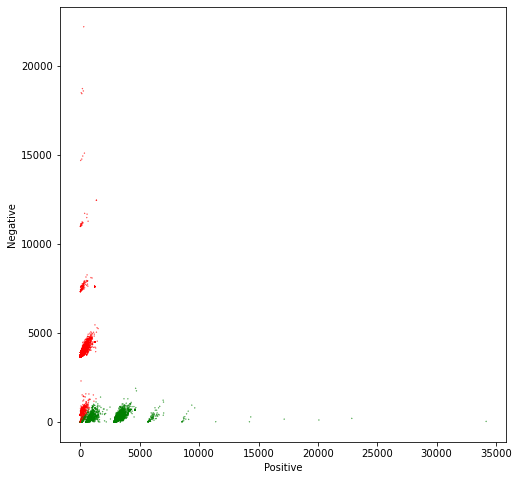

In [27]:
def plot_tweets(X):
    fig, ax = plt.subplots(figsize=(8,8))
    colors = ['red', 'green']
    ax.scatter(X[:, 1], X[:, 2], c=[colors[int(k)] for k in Y], s=0.1)
    plt.xlabel('Positive')
    plt.ylabel('Negative')
    return fig, ax
    
plot_tweets(X)    

From the plot, it is evident that the features that we have chosen to represent tweets as numerical vectors allow an almost perfect separation between positive and negative tweets. So you can expect a very high accuracy for this model! 

## Plot the model alongside the data

We will draw a gray line to show the cutoff between the positive and negative regions. In other words, the gray line marks the line where $$ z = \theta * x = 0.$$
To draw this line, we have to solve the above equation in terms of one of the independent variables.

$$ z = \theta * x = 0$$
$$ x = [1, pos, neg] $$
$$ z(\theta, x) = \theta_0+ \theta_1 * pos + \theta_2 * neg = 0 $$
$$ neg = (-\theta_0 - \theta_1 * pos) / \theta_2 $$

The red and green lines that point in the direction of the corresponding sentiment are calculated using a perpendicular line to the separation line calculated in the previous equations(neg function). It must point in the same direction as the derivative of the Logit function, but the magnitude may differ. It is only for a visual representation of the model. 

$$direction = pos * \theta_2 / \theta_1$$

In [30]:
# given a theta vector and positive sentiment value, return the negative sentiment value
def neg(theta, pos):
    return -theta[0] - (theta[1] / theta[2])* pos

The green line in the chart points in the direction where z > 0 and the red line points in the direction where z < 0. The direction of these lines are given by the weights $\theta_1$ and $\theta_2$

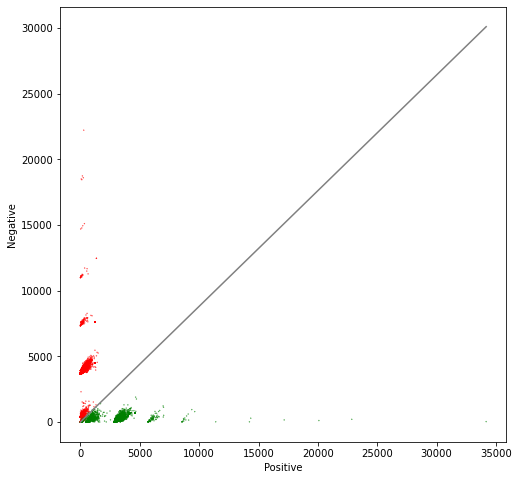

In [31]:
fig, ax = plot_tweets(X)
max_pos = np.max(X[:, 1])
ax.plot([0, max_pos], [neg(theta, 0), neg(theta, max_pos)], color='gray')
plt.show()

**Note that more critical than the Logistic regression itself, are the features extracted from tweets that allow getting the right results in this exercise.**

That is all, folks. Hopefully, now you understand better what the Logistic regression model represents, and why it works that well for this specific problem. 